In [29]:
# import modules
from dotenv import load_dotenv, find_dotenv
import tweepy
import pandas as pd
import numpy as np
import os
import re

import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")
import seaborn as sns
from collections import Counter

import matplotlib.pyplot as plt; plt.rcdefaults()

# nltk 
from nltk.stem.snowball import SnowballStemmer 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# sentimental analisys
from textblob import TextBlob

# roBERTa-base for Sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

# load model and tokenizet
roberta = "cardiffnlp/twitter-roberta-base-sentiment"

model = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta)

lables = ['Negative', 'Neutral', 'Positive']


load_dotenv(find_dotenv())

True

In [17]:
# set online authentication
auth = tweepy.OAuth1UserHandler(os.getenv('consumer_key'), os.getenv('consumer_secret'))
auth.set_access_token (os.getenv('access_token'), os.getenv('access_token_secret'))

# seting up Oauth 2.0 Bearer Token
#auth = tweepy.OAuth2BearerHandler(os.getenv('bearer_token'))

# calling the API
api = tweepy.API(auth)

In [18]:
screen_name = "elonmusk"

# Returns information about the specified user
user = api.get_user(screen_name = screen_name)


In [19]:
# printing the information
print("The id is : " + str(user.id))
print("The id_str is : " + user.id_str)
print("The name is : " + user.name)
print("The screen_name is : " + user.screen_name)
print("The location is : " + str(user.location))
print("The profile_location is : " + str(user.profile_location))
print("The description is : " + user.description)

The id is : 44196397
The id_str is : 44196397
The name is : Elon Musk
The screen_name is : elonmusk
The location is : 
The profile_location is : None
The description is : Mars & Cars, Chips & Dips


In [54]:
screen_name = 'elonmusk'
search_term = 'cardano djed'
tweet_amount = 200
tweets = []
likes = []
time = []

# return most recent status posted
# search by user name
'''
data = tweepy.Cursor(api.user_timeline,
                       screen_name = screen_name,
                       tweet_mode='extended',
                       ).items(tweet_amount)


# return most recent search word
'''
# search by topic
data = tweepy.Cursor(api.search_tweets,
                       q = search_term,
                       lang='en',
                       tweet_mode='extended',
                       ).items(tweet_amount)


# getting data into a lists
for tweet in data:
    #print(tweet.text)
    tweets.append(tweet.full_text)
    likes.append(tweet.favorite_count)
    time.append(tweet.created_at)


In [55]:
tweets

['#Cardano is stronger in this bear market. #BuildingOnCardano added more them 1000 projects … We are going to see many enhancements like Input Endorsers, Hydra, @lace_io wallet with integration to Atala PRISM, #Djed stablecoin and much more…',
 'RT @CryptoVesus: Vasil hard fork &gt; $eth merge\n\n#vasil $coti $ada #cardano $djed $btc #crypto',
 'RT @Cardanians_io: #Cardano will have its own algorithmic stablecoin #Djed. It is already on the test-net. $ada',
 'Vasil hard fork &gt; $eth merge\n\n#vasil $coti $ada #cardano $djed $btc #crypto',
 "RT @DanielTetsuyama: I'm still very much involved with $DJED\n@COTInetwork is doing a fantastic job with this project.\n$DJED will be a game…",
 '@AaireVoltaire I agree and theoretically $djed shud make the cardano ecosystem much more liquid which will help lenders...hence $meld is a strong beneficiary',
 'RT @Cardanians_io: #Cardano will have its own algorithmic stablecoin #Djed. It is already on the test-net. $ada',
 'RT @Cardanians_io: #Cardan

In [69]:
# cleaning tweets, removing mentioned users (@)

tweets_final = []

for tweet in tweets:
    final_text = tweet.replace('&amp;', 'and')
    #final_text = re.sub('^RT ', '', final_text)      # this remove only RT letters
    final_text = re.sub('htt.*', 'http', final_text)
    final_text = re.sub(r'@.\w+', '@user ', final_text)
    tweets_final.append(final_text)


# create data frame
df = pd.DataFrame({'tweets':tweets_final,'likes':likes,'time':time})

# removing retweets (all the line)
df = df[~df.tweets.str.contains("RT")]

# removing links
#df = df[~df.tweets.str.contains("http")]

# reset index
df = df.reset_index(drop=True)

# fb to a list
list_of_sentences = [sentence for sentence in df.tweets]


list_of_sentences[0]

'#Cardano is stronger in this bear market. #BuildingOnCardano added more them 1000 projects … We are going to see many enhancements like Input Endorsers, Hydra, @user  wallet with integration to Atala PRISM, #Djed stablecoin and much more…'

In [102]:
score_Negative = []
score_Neutral = []
score_Positive = []

for tweets in list_of_sentences:

    # sentiment analysis
    encoded_tweet = tokenizer(tweets, return_tensors='pt')
    #output = model(encoded_tweet['input_ids'], encoded_tweet['attention_mask'])
    output = model(**encoded_tweet)

    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    score_Negative.append(scores[0]) 
    score_Neutral.append(scores[1]) 
    score_Positive.append(scores[2]) 


Negative 0.002038898
Neutral 0.08595369
Positive 0.9120075
Negative 0.06384847
Neutral 0.8741736
Positive 0.061977997
Negative 0.0033238656
Neutral 0.13998641
Positive 0.8566897
Negative 0.0010602128
Neutral 0.011897715
Positive 0.98704225
Negative 0.0036288265
Neutral 0.5398491
Positive 0.45652217
Negative 0.0023351235
Neutral 0.545908
Positive 0.45175695
Negative 0.0030702336
Neutral 0.32639915
Positive 0.6705307
Negative 0.04885244
Neutral 0.42978656
Positive 0.521361
Negative 0.01517078
Neutral 0.9120604
Positive 0.072768785
Negative 0.08270341
Neutral 0.8208582
Positive 0.09643838
Negative 0.0016048058
Neutral 0.022141539
Positive 0.9762536
Negative 0.002411669
Neutral 0.15301459
Positive 0.84457386
Negative 0.10935798
Neutral 0.8233354
Positive 0.06730661
Negative 0.004768936
Neutral 0.4019254
Positive 0.59330577
Negative 0.00779167
Neutral 0.77352935
Positive 0.21867895
Negative 0.0056086513
Neutral 0.19650155
Positive 0.79788977
Negative 0.08184354
Neutral 0.88232523
Positive 0

,tweets,tweets_scores
0,#Cardano is stronger in this bear market. #Bui...,"[0.002038898, 0.08595369, 0.9120075]"
1,Vasil hard fork &gt; $eth merge\n\n#vasil $cot...,"[0.06384847, 0.8741736, 0.061977997]"
2,@user I agree and theoretically $djed shud ma...,"[0.0033238656, 0.13998641, 0.8566897]"
3,@user @user $coti power bro 💪\n#cardano fami...,"[0.0010602128, 0.011897715, 0.98704225]"
4,Cardano's Djed Seals New Partnerships. Another...,"[0.0036288265, 0.5398491, 0.45652217]"
5,One other collaboration between Iagon and Djed...,"[0.0023351235, 0.545908, 0.45175695]"
6,"@user After major players like Maladex, Meld,...","[0.0030702336, 0.32639915, 0.6705307]"
7,@user Are you not forgetting $ada #Cardano .....,"[0.04885244, 0.42978656, 0.521361]"
8,COTI’s Djed Partners with Iagon http\n#lagon #...,"[0.01517078, 0.9120604, 0.072768785]"
9,Time for #Djed ⁦@user ⁩ #Cardano #CardanoCommu...,"[0.08270341, 0.8208582, 0.09643838]"


In [109]:
df =pd.DataFrame({'tweets': list_of_sentences, 'negative': score_Negative, 'neutral': score_Neutral, 'positive': score_Positive,})

df

,tweets,negative,neutral,positive
0,#Cardano is stronger in this bear market. #Bui...,0.002039,0.085954,0.912008
1,Vasil hard fork &gt; $eth merge\n\n#vasil $cot...,0.063848,0.874174,0.061978
2,@user I agree and theoretically $djed shud ma...,0.003324,0.139986,0.856690
3,@user @user $coti power bro 💪\n#cardano fami...,0.001060,0.011898,0.987042
4,Cardano's Djed Seals New Partnerships. Another...,0.003629,0.539849,0.456522
5,One other collaboration between Iagon and Djed...,0.002335,0.545908,0.451757
6,"@user After major players like Maladex, Meld,...",0.003070,0.326399,0.670531
7,@user Are you not forgetting $ada #Cardano .....,0.048852,0.429787,0.521361
8,COTI’s Djed Partners with Iagon http\n#lagon #...,0.015171,0.912060,0.072769
9,Time for #Djed ⁦@user ⁩ #Cardano #CardanoCommu...,0.082703,0.820858,0.096438


In [107]:
# Roberta Sentiment Analysis

tweets_proc = []
tweet_words = []
tweets_scores = []

tweets_test = list_of_sentences[46]



for word in tweets_test.split(' '):
    if word.startswith('@') and len(word) > 1:
        word = '@user'

    elif word.startswith('http'):
        word = 'http'
    tweet_words.append(word)

tweet_proc = " ".join(tweet_words)
#tweets_proc.append(tweet_proc)

print(tweet_proc)

# sentiment analysis
encoded_tweet = tokenizer(tweet_proc, return_tensors='pt')
#output = model(encoded_tweet['input_ids'], encoded_tweet['attention_mask'])
output = model(**encoded_tweet)


scores = output[0][0].detach().numpy()
scores = softmax(scores)

# tweets_scores.append(scores)


for i in range(len(scores)):

     l = lables[i]
     s = scores[i]
     print(l,s)



Q3 will be lit for both $COTI and $ADA!

Vasil Hardfork and $DJED stablecoin on #Cardano ecosystem powered by $COTI 🚀💎🙌 http
Negative 0.0011318567
Neutral 0.14184554
Positive 0.8570224


In [57]:
tweets_proc

['#Cardano is stronger in this bear market. #BuildingOnCardano added more them 1000 projects … We are going to see many enhancements like Input Endorsers, Hydra, @user wallet with integration to Atala PRISM, #Djed stablecoin and much more…',
 '#Cardano is stronger in this bear market. #BuildingOnCardano added more them 1000 projects … We are going to see many enhancements like Input Endorsers, Hydra, @user wallet with integration to Atala PRISM, #Djed stablecoin and much more… RT @user Vasil hard fork &gt; $eth merge\n\n#vasil $coti $ada #cardano $djed $btc #crypto',
 '#Cardano is stronger in this bear market. #BuildingOnCardano added more them 1000 projects … We are going to see many enhancements like Input Endorsers, Hydra, @user wallet with integration to Atala PRISM, #Djed stablecoin and much more… RT @user Vasil hard fork &gt; $eth merge\n\n#vasil $coti $ada #cardano $djed $btc #crypto RT @user #Cardano will have its own algorithmic stablecoin #Djed. It is already on the test-net.

In [48]:
# cleaning tweets, removing mentioned users (@)

tweets_final = []

for tweet in tweets:
    final_text = tweet.replace('&amp;', 'and')
    #final_text = re.sub('^RT ', '', final_text)      # this remove only RT letters
    final_text = re.sub('htt.*', '', final_text)


    while final_text.startswith('@'):
            position = final_text.index(' ')
            final_text = final_text[position+1:]        

    #print(final_text)
    tweets_final.append(final_text)


In [50]:
# create data frame
df = pd.DataFrame({'tweets':tweets_final,'likes':likes,'time':time})

# removing retweets (all the line)
df = df[~df.tweets.str.contains("RT")]

# removing links
#df = df[~df.tweets.str.contains("http")]

# reset index
df = df.reset_index(drop=True)

# most like tweetsmostlike = df.loc[df.likes.nlargest(10).index]

In [51]:
# fb to a list
list_of_sentences = [sentence for sentence in df.tweets]

lines = []
for sentence in list_of_sentences:
    words = sentence.split()
    for w in words:
        lines.append(w)

In [52]:
list_of_sentences

['#Cardano is stronger in this bear market. #BuildingOnCardano added more them 1000 projects … We are going to see many enhancements like Input Endorsers, Hydra, @lace_io wallet with integration to Atala PRISM, #Djed stablecoin and much more…',
 'Vasil hard fork &gt; $eth merge\n\n#vasil $coti $ada #cardano $djed $btc #crypto',
 'I agree and theoretically $djed shud make the cardano ecosystem much more liquid which will help lenders...hence $meld is a strong beneficiary',
 '$coti power bro 💪\n#cardano family is so lovely !!! \n#ergo $djed $ada $coti $wmt #CardanoCommunity',
 "Cardano's Djed Seals New Partnerships. Another collaboration between Iagon and Djed, Cardano's overcollateralized algorithmic stablecoin, has been\xa0...Cardano DEX TVL Rises Over 56000% as Cardano Records Massive DeFi Inflows ",
 "One other collaboration between Iagon and Djed, Cardano's overcollateralized algorithmic stablecoin, has been made public by means of the COTI\xa0...Cardano DEX Sees 54000% Rise in TVL 

In [28]:
## sentiment analysis 
polarity = 0

positive = 0
neutral = 0
negative = 0

for raw_text in df.tweets:
    analysis = TextBlob(raw_text)
    tweet_polarity = analysis.polarity
    if tweet_polarity > 0.00:
        positive += 1
    elif tweet_polarity < 0.00:
        negative += 1
    elif tweet_polarity == 0.00:
        neutral += 1
    polarity += tweet_polarity


print(polarity)
print(positive)
print(negative)
print(neutral)

7.438626228269084
22
8
18


In [29]:
# remove punctuaction
lines2 = []

# if it is a currency amount keeps the format
for x in lines:
    if x[0] == '$' and x[1].isdigit():
        lines2.append(x)
    else:
        temp = re.sub(r'[^A-Za-z0-9]+', '', x)
        lines2.append(temp)


# remove empty objects
lines3 = []

for word in lines2:
    if word != '':
        lines3.append(word)


In [30]:
lines3

['Cardano',
 'ADA',
 'Price',
 '$0.44',
 'Change',
 'in',
 '1h',
 '037649301',
 'Market',
 'cap',
 '$15,034,122,420.97',
 'Ranking',
 '8',
 'Cardano',
 'ADA',
 'Cardano',
 'gt',
 '60',
 'days',
 'mean',
 '050830',
 'Cardano',
 'gt',
 '30',
 'days',
 'mean',
 '047042',
 'Price',
 '04414',
 'Fri',
 'Jul',
 '15',
 '060025',
 '2022',
 'Your',
 'hourly',
 'Cardano',
 'update',
 'Hourly',
 'closing',
 'of',
 'ADA',
 '$0.4434',
 'ADAUSD',
 'Hourly',
 'price',
 'change',
 '054',
 '12',
 'hr',
 'Vol',
 'trends',
 'downwards',
 'Trading',
 'below',
 '200',
 'hr',
 'MA04522',
 'RSI',
 '14',
 'at',
 '5893',
 'trade',
 'crypto',
 'ADA',
 'As',
 'in',
 'Today',
 'ADA',
 'Cardano',
 '$0.4418',
 'up',
 '230',
 '24',
 'hrs',
 'The',
 'current',
 'price',
 'of',
 'one',
 'ADA',
 'is',
 '$0.4430,',
 '038',
 'change',
 'in',
 'the',
 'last',
 'hour',
 '283',
 'change',
 'in',
 'the',
 'last',
 '24H',
 'Total',
 'volume',
 'in',
 'the',
 'last',
 '24H',
 '$890,468,229.',
 'Current',
 'CoinMarketCap',
 'Ran

In [31]:
# stemming the words to their word root
s_wnl = WordNetLemmatizer()
s_stemmer = SnowballStemmer(language='english')

stem = []

for word in lines3:
    s_wnl.lemmatize(word) if s_wnl.lemmatize(word).endswith('e') else s_stemmer.stem(word)
    stem.append(word)
    #stem.append(s_wnl.lemmatize(word))
    

In [32]:
# remov all stop words
stop_words = set(stopwords.words("english"))
stem2 = []

for word in stem:
    if word.casefold() not in stop_words:
        stem2.append(word)


In [33]:
# delete all x elements from a list and the search words
search_split = search_term.split()

# add words to remove
to_delete = ['im']

delete_list = to_delete + search_split
new_list = []

for word in stem2:
    if word.casefold() not in delete_list:
        new_list.append(word)


In [34]:
#new_list

In [35]:
df = pd.DataFrame(new_list)

# make all lowercase
df = df.applymap(lambda s:s.lower() if type(s) == str else s)

# group the words
df = df[0].value_counts()

In [36]:
# frecuencies of the words
freqdoctor = FreqDist()

for words in df:
    freqdoctor[words] += 1

freqdoctor

FreqDist({1: 459, 2: 61, 3: 22, 5: 6, 4: 6, 6: 4, 26: 1, 7: 1})

c:\Users\imont\anaconda3\envs\django2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


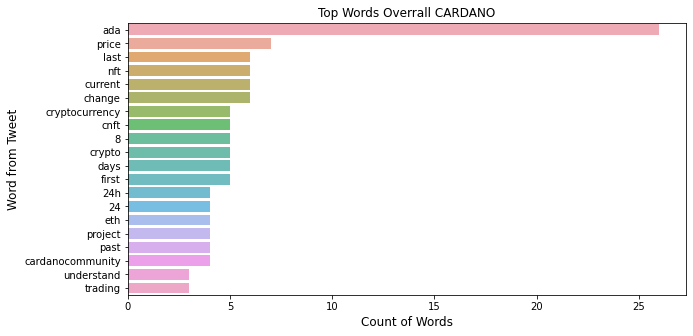

In [37]:
# simple plot that shows the top 20 words being used

df = df[:20]
plt.figure(figsize=(10,5))
sns.barplot(df.values, df.index, alpha=0.8)
plt.title('Top Words Overrall ' + search_term.upper())
plt.ylabel('Word from Tweet', fontsize=12)
plt.xlabel('Count of Words', fontsize=12)
plt.show()

In [38]:
def show_ents(doc):
    if doc.ents:
        for ent in doc.ents:
            print(ent.text +  ' - ' + ent.label_ + ' - ' + str(spacy.explain(ent.label)))

In [39]:
str1 = " "
stem2 = str1.join(lines2)

stem2 = nlp(stem2)

label = [(X.text, X.label_) for X in stem2.ents]

df6 = pd.DataFrame(label, columns = ['Word', 'Entity'])

df7 = df6.where(df6['Entity'] == 'ORG')

df7 = df7['Word'].value_counts()


c:\Users\imont\anaconda3\envs\django2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


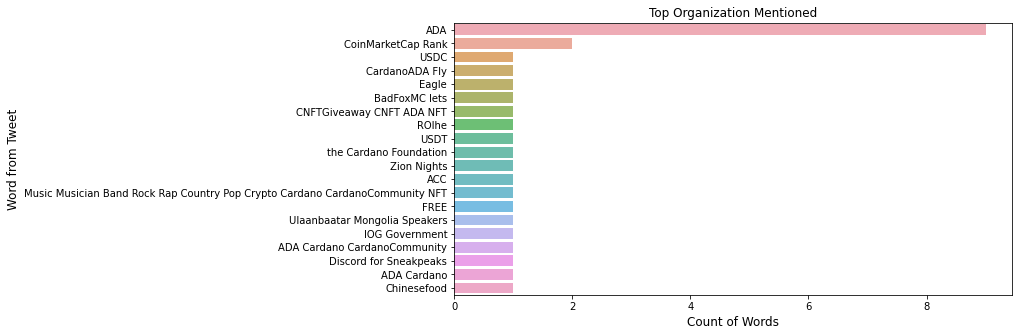

In [40]:
# simple plot that shows the top organiations

df = df7[:20]
plt.figure(figsize=(10,5))
sns.barplot(df.values, df.index, alpha=0.8)
plt.title('Top Organization Mentioned')
plt.ylabel('Word from Tweet', fontsize=12)
plt.xlabel('Count of Words', fontsize=12)
plt.show()

In [240]:
# top persons he is talking aobut

str1 = " "
stem2 = str1.join(lines2)

stem2 = nlp(stem2)

label = [(X.text, X.label_) for X in stem2.ents]

df6 = pd.DataFrame(label, columns = ['Word', 'Entity'])

df7 = df6.where(df6['Entity'] == 'PERSON')

df7 = df7['Word'].value_counts()

c:\Users\imont\anaconda3\envs\django2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


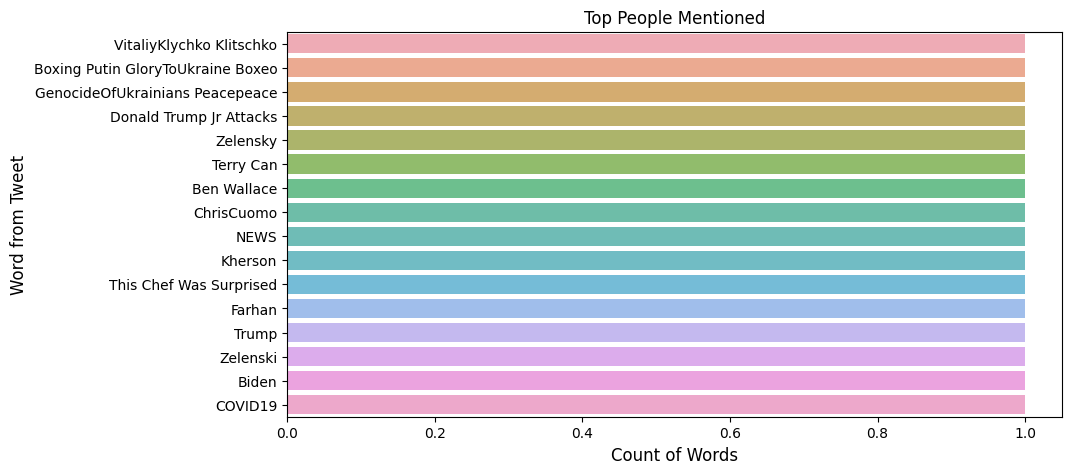

In [241]:
# simple plot that shows the top people mentioned

df = df7[:20]
plt.figure(figsize=(10,5))
sns.barplot(df.values, df.index, alpha=0.8)
plt.title('Top People Mentioned')
plt.ylabel('Word from Tweet', fontsize=12)
plt.xlabel('Count of Words', fontsize=12)
plt.show()